# Week 7

This week, we cover two Convolutional neural networks (CNNs), a type of neural network that replaces the fully-connected hidden layers with so-called convolutional layers. CNNs provide much better performance on data with local structure like images, videos, and time series. They are sometimes used with audio and text as well.

## Lecture 13 - LeNet and Later "Sandwich" CNNs

We will now build toward the next big idea in neural networks: convolutional neural networks (frequently called CNNs or ConvNets). These are nets that take some inspiration from the way neurons are connected in an animal's visual cortex, where different groups of neurons respond to specific portions of the visual field and then those signals are combined in a sort of hierarchy that is thought to allow animals to extract increasingly complex features within the incoming visual stimuli.

CNNs are are feedforward neural networks like we have seen, but neurons in one layer are not necessarily connected to every neuron in the next layer. Such a more complex architecture, in some sense, allows a regularized version of fully-connected nets in that, they can generalize better to test data and to the real world. Recall, we could learn the whole training set for CIFAR-10 but had at least 30% less accuracy on test data.

Another benefit is that this more sparse sort of structure means we can build deeper or wider neural nets without growing the computation as much as fully-connected nets.

CNNs are some of the best algorithms for computer vision problems but have also been used effectively in anomaly detection, time series analysis in financial markets, and predicting the interactions between proteins and molecules in drug discovery among other applications. In particular, they are helpful wherever there is some kind of local structure within the datapoints.

(Please see the class notes for introductory material. We continue with implementing some CNNs.)

### Comparison with Fully-Connected Nets

A big difference between CNNs and the fully-connected nets we have seen is that there are far fewer parameters, which helps avoid overfitting. So, let's import some things from Keras and then create some nets to compare them.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l1_l2

class LeNetReg:
    # create the architecture
    def build(height, width, depth, classes, lam1 = 0, lam2 = 0, dropout = [0, 0, 0, 0.5]):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with 20 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(32, (5, 5), padding = 'same', input_shape = (height, width, depth),
                         kernel_regularizer = l1_l2(l1 = lam1, l2 = lam2)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(dropout[0]))
        
        # add another convolutional layer with 50 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(64, (5, 5), padding= 'same', kernel_regularizer = l1_l2(l1 = lam1, l2 = lam2)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(dropout[1]))
        
        # add another convolutional layer
        model.add(Conv2D(128, (5, 5), padding = 'same', kernel_regularizer = l1_l2(l1 = lam1, l2 = lam2)))
        model.add(Activation('relu'))
        model.add(Dropout(dropout[2]))
        
        # add a fully-connected layer
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))
        
        model.add(Dropout(dropout[3]))
        
        # add a softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the constructed model
        return model

Let's run it on MNIST to see if we can improve our (incredible) 99.4% accuracy!

[INFO] training network...
Epoch 1/10
375/375 [==============================] - 4s 10ms/step - loss: 0.1793 - accuracy: 0.9440 - val_loss: 0.0508 - val_accuracy: 0.9858
Epoch 2/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0465 - accuracy: 0.9852 - val_loss: 0.0388 - val_accuracy: 0.9877
Epoch 3/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0326 - accuracy: 0.9901 - val_loss: 0.0327 - val_accuracy: 0.9903
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0238 - accuracy: 0.9924 - val_loss: 0.0339 - val_accuracy: 0.9899
Epoch 5/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0181 - accuracy: 0.9943 - val_loss: 0.0354 - val_accuracy: 0.9912
Epoch 6/10
375/375 [==============================] - 4s 9ms/step - loss: 0.0154 - accuracy: 0.9953 - val_loss: 0.0443 - val_accuracy: 0.9905
Epoch 7/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0121 - accuracy: 0.9963 - val_loss: 0.0312

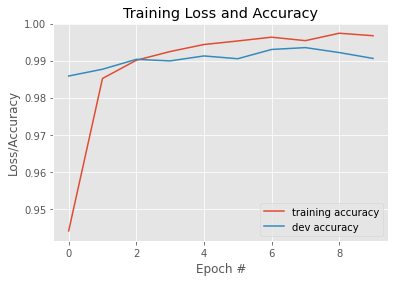

In [15]:
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(28, 28, 1, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxEpoch = 10
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

This is slightly worse, unfortunately, but the prior model was not really overfitting.

Let's try it with CIFAR-10, where we did observe overfitting.

[INFO] training network...
Epoch 1/10
313/313 [==============================] - 4s 12ms/step - loss: 1.6605 - accuracy: 0.3893 - val_loss: 1.3155 - val_accuracy: 0.5220
Epoch 2/10
313/313 [==============================] - 3s 11ms/step - loss: 1.2397 - accuracy: 0.5575 - val_loss: 1.1280 - val_accuracy: 0.6068
Epoch 3/10
313/313 [==============================] - 3s 11ms/step - loss: 1.0445 - accuracy: 0.6340 - val_loss: 0.9792 - val_accuracy: 0.6496
Epoch 4/10
313/313 [==============================] - 3s 11ms/step - loss: 0.9094 - accuracy: 0.6815 - val_loss: 0.8894 - val_accuracy: 0.6878
Epoch 5/10
313/313 [==============================] - 3s 11ms/step - loss: 0.7919 - accuracy: 0.7246 - val_loss: 0.8449 - val_accuracy: 0.7077
Epoch 6/10
313/313 [==============================] - 3s 11ms/step - loss: 0.6931 - accuracy: 0.7584 - val_loss: 0.8240 - val_accuracy: 0.7175
Epoch 7/10
313/313 [==============================] - 3s 11ms/step - loss: 0.6021 - accuracy: 0.7907 - val_loss: 0.

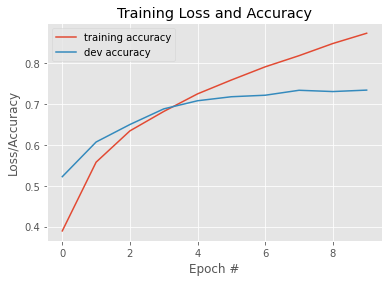

In [16]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxEpoch = 10
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We see a slight improvement, up to 73\%. Let's go back to SGD and see how it compares.

[INFO] training network...
Epoch 1/50
313/313 [==============================] - 4s 11ms/step - loss: 2.1859 - accuracy: 0.1890 - val_loss: 2.0363 - val_accuracy: 0.2758
Epoch 2/50
313/313 [==============================] - 3s 10ms/step - loss: 1.9461 - accuracy: 0.3014 - val_loss: 1.9316 - val_accuracy: 0.3071
Epoch 3/50
313/313 [==============================] - 3s 10ms/step - loss: 1.7999 - accuracy: 0.3555 - val_loss: 1.6687 - val_accuracy: 0.4042
Epoch 4/50
313/313 [==============================] - 3s 10ms/step - loss: 1.6827 - accuracy: 0.3950 - val_loss: 1.5996 - val_accuracy: 0.4306
Epoch 5/50
313/313 [==============================] - 3s 11ms/step - loss: 1.6154 - accuracy: 0.4223 - val_loss: 1.5471 - val_accuracy: 0.4496
Epoch 6/50
313/313 [==============================] - 3s 10ms/step - loss: 1.5489 - accuracy: 0.4447 - val_loss: 1.5067 - val_accuracy: 0.4664
Epoch 7/50
313/313 [==============================] - 3s 11ms/step - loss: 1.4993 - accuracy: 0.4642 - val_loss: 1.

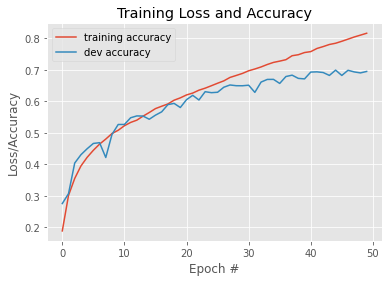

In [17]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])

print("[INFO] training network...")
maxEpoch = 50
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We got worse results with SGD.

### Regularization

Some next steps might be to try regularization. Let's try weight decay (L1 and L2 penalties) since we are seeing overfitting.

In [9]:
from sklearn.metrics import accuracy_score

(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

best_hyperparameters = [0, 0]
best_accuracy = 0

for l1 in [0, 0.001, 0.01, 0.1]:
    for l2 in [0, 0.001, 0.01, 0.1]:
        
        model = LeNetReg.build(32, 32, 3, 10, l1/trainX.shape[0], l2/trainX.shape[0])
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

        maxIt = 20
        H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 0)
        dev_accuracy = H.history['val_accuracy'][-1]
        print('Dev accuracy for l1 =', l1, ', l2 =', l2, 'is', dev_accuracy)
        
        if dev_accuracy > best_accuracy:
            best_accuracy = dev_accuracy
            best_hyperparameters = [l1, l2]

Dev accuracy for l1 = 0 , l2 = 0 is 0.7315000295639038
Dev accuracy for l1 = 0 , l2 = 0.001 is 0.7386000156402588
Dev accuracy for l1 = 0 , l2 = 0.01 is 0.7275999784469604
Dev accuracy for l1 = 0 , l2 = 0.1 is 0.7336000204086304
Dev accuracy for l1 = 0.001 , l2 = 0 is 0.7297999858856201
Dev accuracy for l1 = 0.001 , l2 = 0.001 is 0.7293000221252441
Dev accuracy for l1 = 0.001 , l2 = 0.01 is 0.7347000241279602
Dev accuracy for l1 = 0.001 , l2 = 0.1 is 0.7386999726295471
Dev accuracy for l1 = 0.01 , l2 = 0 is 0.7400000095367432
Dev accuracy for l1 = 0.01 , l2 = 0.001 is 0.7293000221252441
Dev accuracy for l1 = 0.01 , l2 = 0.01 is 0.72079998254776
Dev accuracy for l1 = 0.01 , l2 = 0.1 is 0.7253999710083008
Dev accuracy for l1 = 0.1 , l2 = 0 is 0.7335000038146973
Dev accuracy for l1 = 0.1 , l2 = 0.001 is 0.7355999946594238
Dev accuracy for l1 = 0.1 , l2 = 0.01 is 0.7293999791145325
Dev accuracy for l1 = 0.1 , l2 = 0.1 is 0.7448999881744385


In [10]:
best_hyperparameters

[0.1, 0.1]

Epoch 1/15
313/313 [==============================] - 5s 12ms/step - loss: 1.6290 - accuracy: 0.4053 - val_loss: 1.3492 - val_accuracy: 0.5119
Epoch 2/15
313/313 [==============================] - 4s 11ms/step - loss: 1.1957 - accuracy: 0.5792 - val_loss: 1.0643 - val_accuracy: 0.6309
Epoch 3/15
313/313 [==============================] - 4s 11ms/step - loss: 0.9998 - accuracy: 0.6507 - val_loss: 0.9247 - val_accuracy: 0.6813
Epoch 4/15
313/313 [==============================] - 4s 11ms/step - loss: 0.8557 - accuracy: 0.7051 - val_loss: 0.8796 - val_accuracy: 0.6942
Epoch 5/15
313/313 [==============================] - 4s 11ms/step - loss: 0.7457 - accuracy: 0.7433 - val_loss: 0.8254 - val_accuracy: 0.7258
Epoch 6/15
313/313 [==============================] - 4s 11ms/step - loss: 0.6464 - accuracy: 0.7781 - val_loss: 0.8228 - val_accuracy: 0.7235
Epoch 7/15
313/313 [==============================] - 4s 11ms/step - loss: 0.5537 - accuracy: 0.8140 - val_loss: 0.8048 - val_accuracy: 0.7411

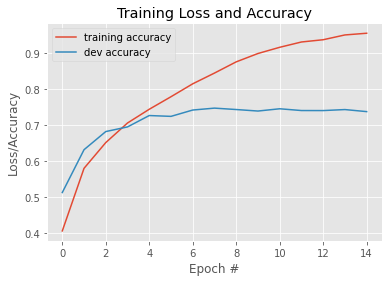

In [11]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10, 0.1/trainX.shape[0], 0.1/trainX.shape[0])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

maxEpoch = 15
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis = 1)
testY = testY.argmax(axis = 1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Here, we gained a couple percentage points, reaching 73.5\% test accuracy!

Let's try modifying the Dropout hyperparameters.

In [21]:
from sklearn.metrics import accuracy_score

(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

for dropout in [[0.1, 0.1, 0.1, 0.5], [0.2, 0.2, 0.2, 0.5], [0.5, 0.5, 0.5, 0.5]]:
        
    model = LeNetReg.build(32, 32, 3, 10, dropout = dropout)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    maxIt = 20
    H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt)
    print('Dev accuracy for dropout percentages', dropout, 'is', H.history['val_accuracy'][-1])

Epoch 1/20
313/313 [==============================] - 4s 12ms/step - loss: 1.6403 - accuracy: 0.3984 - val_loss: 1.3852 - val_accuracy: 0.5143
Epoch 2/20
313/313 [==============================] - 4s 11ms/step - loss: 1.2251 - accuracy: 0.5637 - val_loss: 1.0636 - val_accuracy: 0.6214
Epoch 3/20
313/313 [==============================] - 4s 11ms/step - loss: 1.0471 - accuracy: 0.6304 - val_loss: 0.9484 - val_accuracy: 0.6620
Epoch 4/20
313/313 [==============================] - 4s 11ms/step - loss: 0.9099 - accuracy: 0.6808 - val_loss: 0.8872 - val_accuracy: 0.6922
Epoch 5/20
313/313 [==============================] - 4s 11ms/step - loss: 0.8104 - accuracy: 0.7152 - val_loss: 0.8462 - val_accuracy: 0.7035
Epoch 6/20
313/313 [==============================] - 4s 11ms/step - loss: 0.7256 - accuracy: 0.7444 - val_loss: 0.8018 - val_accuracy: 0.7231
Epoch 7/20
313/313 [==============================] - 4s 11ms/step - loss: 0.6495 - accuracy: 0.7705 - val_loss: 0.7929 - val_accuracy: 0.7308

Dev accuracy jumped to 74.6\% by adding Dropout after the pooling layers.

Epoch 1/20
313/313 [==============================] - 4s 12ms/step - loss: 1.6881 - accuracy: 0.3760 - val_loss: 1.3542 - val_accuracy: 0.4989
Epoch 2/20
313/313 [==============================] - 4s 11ms/step - loss: 1.2797 - accuracy: 0.5422 - val_loss: 1.0909 - val_accuracy: 0.6045
Epoch 3/20
313/313 [==============================] - 4s 11ms/step - loss: 1.1001 - accuracy: 0.6093 - val_loss: 1.0672 - val_accuracy: 0.6290
Epoch 4/20
313/313 [==============================] - 4s 11ms/step - loss: 0.9714 - accuracy: 0.6599 - val_loss: 0.9288 - val_accuracy: 0.6759
Epoch 5/20
313/313 [==============================] - 4s 11ms/step - loss: 0.8876 - accuracy: 0.6899 - val_loss: 0.9192 - val_accuracy: 0.6852
Epoch 6/20
313/313 [==============================] - 4s 11ms/step - loss: 0.8065 - accuracy: 0.7155 - val_loss: 0.7884 - val_accuracy: 0.7260
Epoch 7/20
313/313 [==============================] - 4s 11ms/step - loss: 0.7428 - accuracy: 0.7391 - val_loss: 0.8094 - val_accuracy: 0.7228

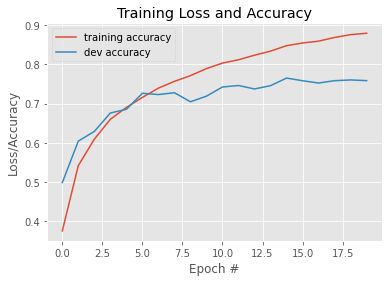

In [22]:
from sklearn.metrics import accuracy_score

(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10, dropout = [0.2, 0.2, 0.2, 0.5])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

maxEpoch = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis = 1)
testY = testY.argmax(axis = 1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We improve even further to about 75\% test accuracy.

For a final test, let's try L1, L2, and enhanced dropout.

Epoch 1/50
313/313 [==============================] - 5s 13ms/step - loss: 1.7244 - accuracy: 0.3694 - val_loss: 1.3721 - val_accuracy: 0.5173
Epoch 2/50
313/313 [==============================] - 4s 12ms/step - loss: 1.3093 - accuracy: 0.5361 - val_loss: 1.1340 - val_accuracy: 0.6055
Epoch 3/50
313/313 [==============================] - 4s 12ms/step - loss: 1.1227 - accuracy: 0.6090 - val_loss: 1.0413 - val_accuracy: 0.6384
Epoch 4/50
313/313 [==============================] - 4s 12ms/step - loss: 1.0049 - accuracy: 0.6484 - val_loss: 0.9217 - val_accuracy: 0.6830
Epoch 5/50
313/313 [==============================] - 4s 12ms/step - loss: 0.9050 - accuracy: 0.6868 - val_loss: 0.8649 - val_accuracy: 0.6996
Epoch 6/50
313/313 [==============================] - 4s 12ms/step - loss: 0.8472 - accuracy: 0.7068 - val_loss: 0.8350 - val_accuracy: 0.7172
Epoch 7/50
313/313 [==============================] - 4s 12ms/step - loss: 0.7844 - accuracy: 0.7296 - val_loss: 0.8579 - val_accuracy: 0.7142

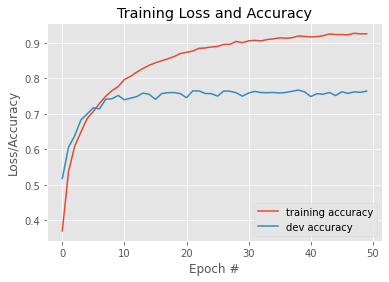

In [23]:
from sklearn.metrics import accuracy_score

(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

n = trainX.shape[0]

model = LeNetReg.build(32, 32, 3, 10, lam1 = 0.1/n, lam2 = 0.1/n, dropout = [0.2, 0.2, 0.2, 0.5])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

maxEpoch = 50
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis = 1)
testY = testY.argmax(axis = 1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

The performance is still above 75\%, sometimes hitting 76\%, which is great!

## Lecture 14 - Deep CNNs: AlexNet, VGGNet

### AlexNet

In [19]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
class AlexNet:
    def build(height, width, depth, classes, lambda2 = 0.0002):
        model = Sequential(name = 'AlexNet')
        
        model.add(Conv2D(96, (11, 11), strides = (4, 4), input_shape = (height, width, depth),
                         padding='same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, (5, 5), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(256, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        model.add(Dense(4096, kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(4096, kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes, kernel_regularizer = l2(lambda2)))
        model.add(Activation('softmax'))
        
        return model

In [4]:
tf.keras.backend.clear_session()

from tensorflow.keras.optimizers import Adam

model = AlexNet.build(227, 227, 3, 1000)
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

print(model.summary())

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 57, 57, 96)        34944     
                                                                 
 activation (Activation)     (None, 57, 57, 96)        0         
                                                                 
 batch_normalization (BatchN  (None, 57, 57, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 28, 28, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       6146

### MiniVGGNet

In [17]:
class MiniVGGNet:
    def build(height, width, depth, classes):
        model = Sequential(name = 'MiniVGGNet')
        
        model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

Model: "MiniVGGNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 activation_6 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_5 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                        

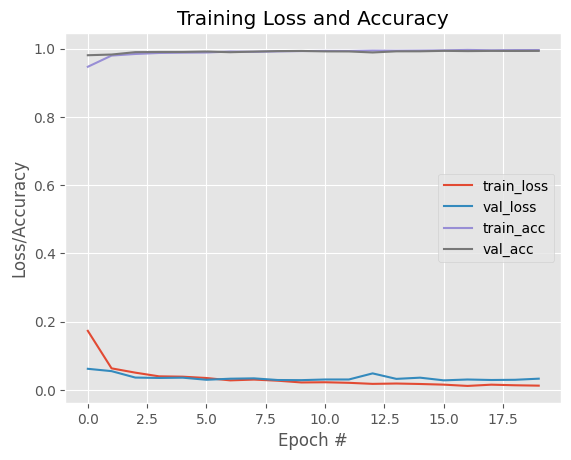

In [21]:
((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = MiniVGGNet.build(28, 28, 1, 10)
opt = Adam()
#opt = SGD(learning_rate = 0.01, decay = 0.1 / 100, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

print(model.summary())

print("[INFO] training network...")
maxIt = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 64, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Model: "MiniVGGNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

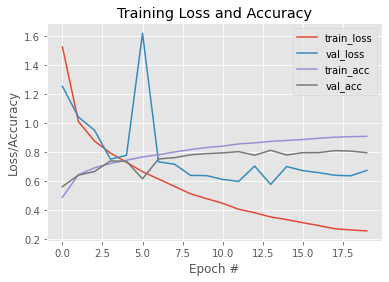

In [7]:
#tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = MiniVGGNet.build(32, 32, 3, 10)
opt = Adam()
#opt = SGD(learning_rate = 0.01, decay = 0.1 / 100, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

print(model.summary())

print("[INFO] training network...")
maxIt = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 64, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### VGGNet16 and VGGNet19

These nets can be expensive to run, but let's write classes for them.

In [5]:
class VGGNet16:
    def build(height, width, depth, classes):
        model = Sequential(name = 'VGGNet16')
        
        # conv 1
        model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 2
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 3
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 4
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 5
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 6
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 7
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 8
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 9
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 10
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 11
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 12
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 13
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        # fc 14
        model.add(Dense(4096))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fc 15
        model.add(Dense(4096))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fc 16
        model.add(Dense(1000))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the model
        return model

Let's take a look at the size of the model.

In [9]:
model = VGGNet16.build(224, 224, 3, 1000)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])

print(model.summary())

Model: "VGGNet16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 activation_6 (Activation)   (None, 224, 224, 64)      0         
                                                                 
 batch_normalization_5 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 activation_7 (Activation)   (None, 224, 224, 64)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                          

In [6]:
class VGGNet19:
    def build(height, width, depth, classes):
        model = Sequential(name = 'VGGNet19')
        
        # conv 1
        model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 2
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 3
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 4
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 5
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 6
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 7
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 8
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 9
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 10
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 11
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 12
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 13
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 14
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 15
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 16
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        # fc 17
        model.add(Dense(4096))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fc 18
        model.add(Dense(4096))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fc 19
        model.add(Dense(1000))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the model
        return model

In [11]:
model = VGGNet19.build(224, 224, 3, 1000)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])

print(model.summary())

Model: "VGGNet19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 activation_23 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 batch_normalization_21 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 activation_24 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 batch_normalization_22 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                         

### Dogs vs. Cats

Let's test these nets along with the preprocessor and data loader on the Dogs vs. Cats dataset from Kaggle (https://www.kaggle.com/c/dogs-vs-cats). This is a higher dimensional dataset than we have used in the past, with image sizes ranging from 50x50 to 500x500 in all different aspect ratios. We will simply distort them to be square images to see how it works.

This is a pretty challenging dataset because we have cats of all different colors and from different angles while the dogs come from many diffrent breeds, in different colors, and so on. CNNs are particularly well-suited to image recognition, so we will try a few modern CNN architectures with the dataset.

The code below assumes the dataset is stored in `../data/dogs-vs-cats/`, i.e. in the data folder one level up from this notebook file.

First, let's make a new MiniVGGNet with preprocessing layers.

In [28]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Reshape

In [ ]:
class MiniVGGNet:
    def build(height, width, depth, classes):
        model = Sequential(name = 'MiniVGGNet')
        
        model.add(Reshape((height, width, depth)))
        model.add(Rescaling(1./255))
        
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model
    
class AlexNet:
    def build(height, width, depth, classes, lambda2 = 0.0002):
        model = Sequential(name = 'AlexNet')
        
        model.add(Reshape((height, width, depth)))
        model.add(Rescaling(1./255))
        
        model.add(Conv2D(96, (11, 11), strides = (4, 4), padding='same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, (5, 5), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(256, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        model.add(Dense(4096, kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(4096, kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes, kernel_regularizer = l2(lambda2)))
        model.add(Activation('softmax'))
        
        return model

In [13]:
data_directory = '../data/dogs-vs-cats'

#### 32x32 Experiment

First, let's try 32x32 images.

Creating Training Dataset

Found 25000 files belonging to 2 classes.
Using 20000 files for training.

Creating Validation Dataset

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.

Training Model

Epoch 1/100
625/625 [==============================] - 12s 17ms/step - loss: 0.6962 - accuracy: 0.6599 - val_loss: 0.5500 - val_accuracy: 0.7192
Epoch 2/100
625/625 [==============================] - 11s 17ms/step - loss: 0.5337 - accuracy: 0.7365 - val_loss: 0.5472 - val_accuracy: 0.7272
Epoch 3/100
625/625 [==============================] - 11s 17ms/step - loss: 0.4885 - accuracy: 0.7611 - val_loss: 0.4624 - val_accuracy: 0.7840
Epoch 4/100
625/625 [==============================] - 11s 17ms/step - loss: 0.4543 - accuracy: 0.7867 - val_loss: 0.6137 - val_accuracy: 0.7082
Epoch 5/100
625/625 [==============================] - 11s 17ms/step - loss: 0.4220 - accuracy: 0.8051 - val_loss: 0.5117 - val_accuracy: 0.7648
Epoch 6/100
625/625 [==============================]

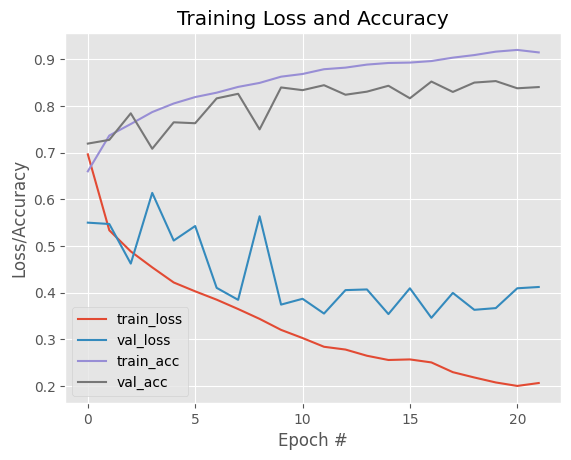

In [93]:
image_height = 32
image_width = 32
image_depth = 3

print('Creating Training Dataset\n')
train_ds = image_dataset_from_directory(directory=data_directory,
                                        validation_split=0.2,
                                        subset='training',
                                        seed=0,
                                        image_size=(image_height, image_width))

print('\nCreating Validation Dataset\n')
val_ds = image_dataset_from_directory(directory=data_directory,
                                      validation_split=0.2,
                                      subset='validation',
                                      seed=0,
                                      image_size=(image_height, image_width))

# build a model
model = MiniVGGNet.build(image_height, image_width, image_depth, 2)

# prepare the model for training
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
early_stopper = EarlyStopping(patience=5, restore_best_weights=True)

print('\nTraining Model\n')
epochs=100
H = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1, callbacks=[early_stopper])

print('\nEvaluating Model of Validation Dataset\n')
# set up val data for classification report
true_labels = np.array([])
val_points = np.zeros((0, image_height, image_width, image_depth))

for x, y in val_ds:
    val_points = np.vstack([val_points, x.numpy()])
    true_labels = np.append(true_labels, y.numpy())
    
# predict val labels
predicted_probabilities = model.predict(val_points)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
    
report = classification_report(true_labels, predicted_labels, target_names=val_ds.class_names)
print(report)

# plot the training loss and accuracy
stopping_epoch = len(H.history['loss'])
plt.style.use('ggplot')
plt.figure()
plt.plot(range(stopping_epoch), H.history['loss'], label='train_loss')
plt.plot(range(stopping_epoch), H.history['val_loss'], label='val_loss')
plt.plot(range(stopping_epoch), H.history['accuracy'], label='train_acc')
plt.plot(range(stopping_epoch), H.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

#### 64x64 Experiment

Next, let's try 64x64 to see if a higher resolution helps.

Creating Training Dataset

Found 25000 files belonging to 2 classes.
Using 20000 files for training.

Creating Validation Dataset

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.

Training Model

Epoch 1/100
625/625 [==============================] - 16s 23ms/step - loss: 0.6950 - accuracy: 0.6673 - val_loss: 0.5738 - val_accuracy: 0.6886
Epoch 2/100
625/625 [==============================] - 15s 24ms/step - loss: 0.5125 - accuracy: 0.7490 - val_loss: 0.4728 - val_accuracy: 0.7682
Epoch 3/100
625/625 [==============================] - 15s 24ms/step - loss: 0.4586 - accuracy: 0.7854 - val_loss: 0.4470 - val_accuracy: 0.7904
Epoch 4/100
625/625 [==============================] - 15s 24ms/step - loss: 0.4071 - accuracy: 0.8145 - val_loss: 0.4327 - val_accuracy: 0.8068
Epoch 5/100
625/625 [==============================] - 15s 24ms/step - loss: 0.4053 - accuracy: 0.8181 - val_loss: 0.9177 - val_accuracy: 0.6266
Epoch 6/100
625/625 [==============================]

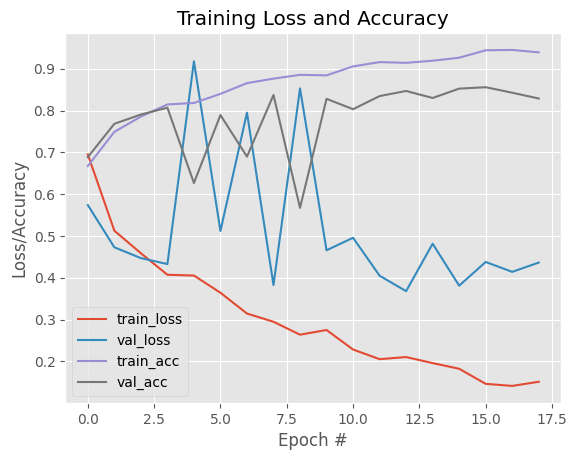

In [94]:
image_height = 64
image_width = 64
image_depth = 3

print('Creating Training Dataset\n')
train_ds = image_dataset_from_directory(directory=data_directory,
                                        validation_split=0.2,
                                        subset='training',
                                        seed=0,
                                        image_size=(image_height, image_width))

print('\nCreating Validation Dataset\n')
val_ds = image_dataset_from_directory(directory=data_directory,
                                      validation_split=0.2,
                                      subset='validation',
                                      seed=0,
                                      image_size=(image_height, image_width))

# build a model
model = MiniVGGNet.build(image_height, image_width, image_depth, 2)

# prepare the model for training
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
early_stopper = EarlyStopping(patience=5, restore_best_weights=True)

print('\nTraining Model\n')
epochs=100
H = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1, callbacks=[early_stopper])

print('\nEvaluating Model of Validation Dataset\n')
# set up val data for classification report
true_labels = np.array([])
val_points = np.zeros((0, image_height, image_width, image_depth))

for x, y in val_ds:
    val_points = np.vstack([val_points, x.numpy()])
    true_labels = np.append(true_labels, y.numpy())
    
# predict val labels
predicted_probabilities = model.predict(val_points)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
    
report = classification_report(true_labels, predicted_labels, target_names=val_ds.class_names)
print(report)

# plot the training loss and accuracy
stopping_epoch = len(H.history['loss'])
plt.style.use('ggplot')
plt.figure()
plt.plot(range(stopping_epoch), H.history['loss'], label='train_loss')
plt.plot(range(stopping_epoch), H.history['val_loss'], label='val_loss')
plt.plot(range(stopping_epoch), H.history['accuracy'], label='train_acc')
plt.plot(range(stopping_epoch), H.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

#### 224 x 224 Experiment 1 (MiniVGGNet)

Let's try a larger resolution!

In [ ]:
image_height = 224
image_width = 224
image_depth = 3

print('Creating Training Dataset\n')
train_ds = image_dataset_from_directory(directory=data_directory,
                                        validation_split=0.2,
                                        subset='training',
                                        seed=0,
                                        image_size=(image_height, image_width))

print('\nCreating Validation Dataset\n')
val_ds = image_dataset_from_directory(directory=data_directory,
                                      validation_split=0.2,
                                      subset='validation',
                                      seed=0,
                                      image_size=(image_height, image_width))

# build a model
model = MiniVGGNet.build(image_height, image_width, image_depth, 2)

# prepare the model for training
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
early_stopper = EarlyStopping(patience=5, restore_best_weights=True)

print('\nTraining Model\n')
epochs=100
H = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1, callbacks=[early_stopper])

print('\nEvaluating Model of Validation Dataset\n')
# set up val data for classification report
true_labels = np.array([])
val_points = np.zeros((0, image_height, image_width, image_depth))

for x, y in val_ds:
    val_points = np.vstack([val_points, x.numpy()])
    true_labels = np.append(true_labels, y.numpy())
    
# predict val labels
predicted_probabilities = model.predict(val_points)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
    
report = classification_report(true_labels, predicted_labels, target_names=val_ds.class_names)
print(report)

# plot the training loss and accuracy
stopping_epoch = len(H.history['loss'])
plt.style.use('ggplot')
plt.figure()
plt.plot(range(stopping_epoch), H.history['loss'], label='train_loss')
plt.plot(range(stopping_epoch), H.history['val_loss'], label='val_loss')
plt.plot(range(stopping_epoch), H.history['accuracy'], label='train_acc')
plt.plot(range(stopping_epoch), H.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

Creating Training Dataset

Found 25000 files belonging to 2 classes.
Using 20000 files for training.

Creating Validation Dataset

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.

Training Model

Epoch 1/100
625/625 [==============================] - 49s 75ms/step - loss: 0.7325 - accuracy: 0.6224 - val_loss: 0.6351 - val_accuracy: 0.6346
Epoch 2/100
625/625 [==============================] - 47s 75ms/step - loss: 0.5911 - accuracy: 0.6859 - val_loss: 0.6263 - val_accuracy: 0.6604
Epoch 3/100
625/625 [==============================] - 47s 75ms/step - loss: 0.5237 - accuracy: 0.7409 - val_loss: 0.5301 - val_accuracy: 0.7308
Epoch 4/100
 63/625 [==>...........................] - ETA: 39s - loss: 0.5072 - accuracy: 0.7644

#### 224 x 224 Experiment 2 (AlexNet)

Let's try AlexNet

In [ ]:
image_height = 224
image_width = 224
image_depth = 3

print('Creating Training Dataset\n')
train_ds = image_dataset_from_directory(directory=data_directory,
                                        validation_split=0.2,
                                        subset='training',
                                        seed=0,
                                        image_size=(image_height, image_width))

print('\nCreating Validation Dataset\n')
val_ds = image_dataset_from_directory(directory=data_directory,
                                      validation_split=0.2,
                                      subset='validation',
                                      seed=0,
                                      image_size=(image_height, image_width))

# build a model
model = AlexNet.build(image_height, image_width, image_depth, 2)

# prepare the model for training
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
early_stopper = EarlyStopping(patience=5, restore_best_weights=True)

print('\nTraining Model\n')
epochs=100
H = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1, callbacks=[early_stopper])

print('\nEvaluating Model of Validation Dataset\n')
# set up val data for classification report
true_labels = np.array([])
val_points = np.zeros((0, image_height, image_width, image_depth))

for x, y in val_ds:
    val_points = np.vstack([val_points, x.numpy()])
    true_labels = np.append(true_labels, y.numpy())
    
# predict val labels
predicted_probabilities = model.predict(val_points)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
    
report = classification_report(true_labels, predicted_labels, target_names=val_ds.class_names)
print(report)

# plot the training loss and accuracy
stopping_epoch = len(H.history['loss'])
plt.style.use('ggplot')
plt.figure()
plt.plot(range(stopping_epoch), H.history['loss'], label='train_loss')
plt.plot(range(stopping_epoch), H.history['val_loss'], label='val_loss')
plt.plot(range(stopping_epoch), H.history['accuracy'], label='train_acc')
plt.plot(range(stopping_epoch), H.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()